# Анализ сервиса аренды самокатов GoFast

Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.
<a id="payment"></a>
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

* без подписки

    * абонентская плата **отсутствует**;
    * стоимость одной минуты поездки — **8 рублей**;
    * стоимость старта (начала поездки) — **50 рублей**;

* с подпиской Ultra

    * абонентская плата — **199 рублей в месяц**;
    * стоимость одной минуты поездки — **6 рублей**;
    * стоимость старта — **бесплатно**.

**Цель исследования:** выяснить, стоит ли продакт-менеджерам сервиса (далее - Заказчик) проводить различные акции для увеличиения количества пользователей с подпиской.

**Вопросы заказчика:**

1. Тратят ли пользователи с подпиской больше времени на поездки?
2. Расстояние одной поездки в 3 130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3 130 метров?
3. Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
---
*Дополнительный вопрос:*

4. Снизится ли количество обращений в техподдержку, если техническая команда сервиса обновит сервера, с которыми взаимодействует мобильное приложение?

**Исходные данные:** данные сервиса GoFast о пользователях из нескольких городов, а также об их поездках.

<a id="documentation"></a>
**Описание данных:**

<u>**(1) Пользователи — users_go.csv</u>**

* **`user_id`** — уникальный идентификатор пользователя
* **`name`** — имя пользователя
* **`age`** — возраст
* **`city`** — город
* **`subscription_type`** — тип подписки (free, ultra)

<u>**(2) Поeздки — rides_go.csv</u>**

* **`user_id`** — уникальный идентификатор пользователя
* **`distance`** — расстояние, которое пользователь проехал в текущей сессии (в метрах)
* **`duration`** — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
* **`date`** — дата совершения поездки

<u>**(3) Подписки — subscriptions_go.csv</u>**

* **`subscription_type`** — тип подписки
* **`minute_price`** — стоимость одной минуты поездки по данной подписке
* **`start_ride_price`** — стоимость начала поездки
* **`subscription_fee`** — стоимость ежемесячного платежа

## Шаг 1. Загрузка данных

**(1) Импортируем библиотеки Pandas и NumPy, подключаем модуль модуль Pyplot из библиотеки Matplotlib и модуль Stats из библиотеки SciPy:**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

**(2) Cбрасываем ограничение на число выводимых столбцов таблицы:**

In [2]:
pd.set_option('display.max_columns', None)

**(3) Добавим разделитель разрядов и оставим 2 знака после запятой для числовых значений (тип данных: float):**

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

### 1.1 Пользователи (data_users) <a id="users_first"></a>

**(1) Импортируем файл CSV-формата в датафрейм:**

In [4]:
try:
    data_users = pd.read_csv('other/documents/users_go.csv', sep=',')
except:
    data_users = pd.read_csv('/datasets/users_go.csv', sep=',')

**(2) Выведем первые строки таблицы:**

In [5]:
data_users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


**(3) Выведем сводную информацию по всему датасету:**

In [6]:
data_users.info()

print('\nВсего строк:', data_users.shape[0])
print('Всего столбцов:', data_users.shape[1])

print('\nКоличество явных дубликатов:', data_users.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB

Всего строк: 1565
Всего столбцов: 5

Количество явных дубликатов: 31


**(4) Выведем информацию по количеству пропущенных значений в каждом столбце:**

In [7]:
print(data_users.isna().sum())

total_isna = []
for value in data_users.isna().sum():
    if value != 0:
        total_isna.append(value)

print('\nКоличество столбцов с пропущенными значениями:', len(total_isna))

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Количество столбцов с пропущенными значениями: 0


**(5) Проверим список уникальных значений столбца `city` на наличие неявных дубликатов:**

In [8]:
print('Количество уникальных значений:', data_users['city'].nunique())

print()

city_name_sorted = data_users.sort_values(by='city', ascending=True)
city_name_sorted = city_name_sorted['city'].unique()

for name in city_name_sorted:
    print(name)

Количество уникальных значений: 8

Екатеринбург
Краснодар
Москва
Омск
Пятигорск
Ростов-на-Дону
Сочи
Тюмень


**(6) Cгенерируем описательную статистику для столбца 'age' для проверки наличия аномальных значений (артефактов):**

In [9]:
data_users['age'].describe()

count   1,565.00
mean       24.92
std         4.55
min        12.00
25%        22.00
50%        25.00
75%        28.00
max        43.00
Name: age, dtype: float64

### 1.2 Поeздки (data_rides) <a id="rides_first"></a>

**(1) Импортируем файл CSV-формата в датафрейм:**

In [10]:
try:
    data_rides = pd.read_csv('other/documents/rides_go.csv', sep=',')
except:
    data_rides = pd.read_csv('/datasets/rides_go.csv', sep=',')

**(2) Выведем первые строки таблицы:**

In [11]:
data_rides.head()

,user_id,distance,duration,date
0,1,"4,409.92",25.60,2021-01-01
1,1,"2,617.59",15.82,2021-01-18
2,1,754.16,6.23,2021-04-20
3,1,"2,694.78",18.51,2021-08-11
4,1,"4,028.69",26.27,2021-08-28


**(3) Выведем сводную информацию по всему датасету:**

In [12]:
data_rides.info()

print('\nВсего строк:', data_rides.shape[0])
print('Всего столбцов:', data_rides.shape[1])

print('\nКоличество явных дубликатов:', data_rides.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB

Всего строк: 18068
Всего столбцов: 4

Количество явных дубликатов: 0


**(4) Выведем информацию по количеству пропущенных значений в каждом столбце:**

In [13]:
print(data_rides.isna().sum())

total_isna = []
for value in data_rides.isna().sum():
    if value != 0:
        total_isna.append(value)

print('\nКоличество столбцов с пропущенными значениями:', len(total_isna))

user_id     0
distance    0
duration    0
date        0
dtype: int64

Количество столбцов с пропущенными значениями: 0


**(5) Cгенерируем описательную статистику для столбцов `distance` и `duration` для проверки наличия аномальных значений (артефактов):**

In [14]:
print(data_rides['distance'].describe())

print()

print(data_rides['duration'].describe())

count   18,068.00
mean     3,070.66
std      1,116.83
min          0.86
25%      2,543.23
50%      3,133.61
75%      3,776.22
max      7,211.01
Name: distance, dtype: float64

count   18,068.00
mean        17.81
std          6.09
min          0.50
25%         13.60
50%         17.68
75%         21.72
max         40.82
Name: duration, dtype: float64


### 1.3 Подписки (data_subscriptions) <a id="subscriptions_first"></a>

**(1) Импортируем файл CSV-формата в датафрейм:**

In [15]:
try:
    data_subscriptions = pd.read_csv('other/documents/subscriptions_go.csv', sep=',')
except:
    data_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv', sep=',')

**(2) Выведем первые строки таблицы:**

In [16]:
data_subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**(3) Выведем сводную информацию по всему датасету:**

In [17]:
data_subscriptions.info()

print('\nВсего строк:', data_subscriptions.shape[0])
print('Всего столбцов:', data_subscriptions.shape[1])

print('\nКоличество явных дубликатов:', data_subscriptions.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes

Всего строк: 2
Всего столбцов: 4

Количество явных дубликатов: 0


**(4) Выведем информацию по количеству пропущенных значений в каждом столбце:**

In [18]:
print(data_subscriptions.isna().sum())

total_isna = []
for value in data_subscriptions.isna().sum():
    if value != 0:
        total_isna.append(value)

print('\nКоличество столбцов с пропущенными значениями:', len(total_isna))

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Количество столбцов с пропущенными значениями: 0


<a id="firstresults"></a>
### <u>**Результаты и выявленные проблемы первичного анализа данных**</u>

**[(1) Пользователи (data_users)](#users_first)**

1. Датафрейм состоит из **1 565 строк** и **5 столбцов** различных типов данных:

     * **object** (текстовые или смешанные числовые и нечисловые значения) - 3 столбца;
     * **int** (целые числа) - 2 столбца;

2. **Названия столбцов соответствуют стилю "змеиного регистра"**;

3. **Столбцов с пропущенными значеняими НЕ выявлено**;

4. **Типы данных соответствуют опсанию столбцов из [документации](#documentation)**;

5. Выявлен **31 явный дубликат**;

6. **Неявных дубликатов НЕ выявлено**;

7. **Аномальные значения (артефакты) отсутствуют**.

In [19]:
# зафиксируем размер датасета до начала предобработки

size_users = data_users.shape[0]
size_users

1565

---
**[(2) Поeздки (data_rides)](#rides_first)**

1. Датафрейм состоит из **18 068 строк** и **4 столбцов** различных типов данных:

     * **float** (вещественные числа) - 2 столбца;
     * **int** (целые числа) - 1 столбец;
     * **object** (текстовые или смешанные числовые и нечисловые значения) - 1 столбец;

2. **Названия столбцов соответствуют стилю "змеиного регистра"**;

3. **Столбцов с пропущенными значеняими НЕ выявлено**;

4. Наблюдается **несоответствие типа данных столбцов описанию из [документации](#documentation)**:

    * `date` - текущий тип данных **object** (текстовые или смешанные числовые и нечисловые значения) необходимо заменить на **datetime** (дата и время);

5. **Явных дубликатов НЕ выявлено**;

6. **Неявных дубликатов НЕ выявлено**;

7. **Аномальные значения (артефакты) отсутствуют**.

In [20]:
# зафиксируем размер датасета до начала предобработки

size_rides = data_rides.shape[0]
size_rides

18068

---
**[(3) Подписки (data_subscriptions)](#subscriptions_first)**

1. Датафрейм состоит из **2 строк** и **4 столбцов** различных типов данных:

     * **int** (целые числа) - 3 столбца;
     * **object** (текстовые или смешанные числовые и нечисловые значения) - 1 столбец;

2. **Названия столбцов соответствуют стилю "змеиного регистра"**;

3. **Столбцов с пропущенными значеняими НЕ выявлено**;

4. **Типы данных соответствуют опсанию столбцов из [документации](#documentation)**;

5. **Явных дубликатов НЕ выявлено**;

6. **Неявных дубликатов НЕ выявлено**;

7. **Аномальные значения (артефакты) отсутствуют**.

In [21]:
# Зафиксируем размер датасета до начала предобработки

size_subscriptions = data_subscriptions.shape[0]
size_subscriptions

2

## Шаг 2. Предобработка данных

### 2.1 Пользователи (data_users) <a id="users_last"></a>

**(1) Устраним явные дубликаты:**

In [22]:
data_users.drop_duplicates(inplace=True)

**(2) Выведем обновлённую сводную информацию по всему датасету:**

In [23]:
data_users.info()

print('\nВсего строк:', data_users.shape[0])
print('Всего столбцов:', data_users.shape[1])

print('\nКоличество явных дубликатов:', data_users.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB

Всего строк: 1534
Всего столбцов: 5

Количество явных дубликатов: 0


**(3) Выведем первые строки обновлённого датафрейма:**

In [24]:
data_users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


### 2.2 Поeздки (data_rides) <a id="rides_last"></a>

**(1) Изменим тип данных *object* (текстовые или смешанные числовые и нечисловые значения) на *datetime* (дата и время) в столбце `date`:**

In [25]:
data_rides['date'] = pd.to_datetime(data_rides['date'], format = '%Y-%m-%d')

**(2) Добавим стоолбец `month` с номером месяца:**

In [26]:
data_rides['month'] = data_rides['date'].dt.month

**(3) Выведем обновлённую сводную информацию по всему датасету:**

In [27]:
data_rides.info()

print('\nВсего строк:', data_rides.shape[0])
print('Всего столбцов:', data_rides.shape[1])

print('\nКоличество явных дубликатов:', data_rides.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB

Всего строк: 18068
Всего столбцов: 5

Количество явных дубликатов: 0


---
**(4) Проверим, за какой период представлены данные в датафрейме. Для этого сделаем следующее:**

* по аналогии со столбцом `month` добавим столбец `year` (год совершения поездки);
* выведем уникальные значения столбца `year`.

In [28]:
data_rides['year'] = data_rides['date'].dt.year

data_rides['year'].unique()

array([2021], dtype=int64)

**(5) Выведем первые строки обновлённого датафрейма:**

In [29]:
data_rides.head()

,user_id,distance,duration,date,month,year
0,1,"4,409.92",25.60,2021-01-01,1,2021
1,1,"2,617.59",15.82,2021-01-18,1,2021
2,1,754.16,6.23,2021-04-20,4,2021
3,1,"2,694.78",18.51,2021-08-11,8,2021
4,1,"4,028.69",26.27,2021-08-28,8,2021


### 2.3 Подписки (data_subscriptions) <a id="subscriptions_last"></a>

Данные корректны, дополнительных манипуляций не требуется.

<a id="preprocessingresults"></a>
### <u>**Результаты предобработки данных**</u>

**[(1) Пользователи (data_users)](#users_last)**

1. **Явные дубликаты удалены** из датафрейма;

2. После проведённых манпуляций датафрейм имеет следующие параметры: **1 534 строки** и **5 столбцов**:

     * **object** (текстовые или смешанные числовые и нечисловые значения) - 3 столбца;
     * **int** (целые числа) - 2 столбца;

---
**[(2) Поeздки (data_rides)](#rides_last)**

1. **Тип данных** в столбце `date` **изменён**. Теперь все столбцы соответствуют описанию из [документации](#documentation), и их можно использовать для дальнейшего анализа;

2. Добавлен **1 новый столбец:**

* `month` (месяц совершения поездки)

3. После проведённых манпуляций датафрейм имеет следующие параметры: **18 068 строк** и **5 столбцов**:

     * **float** (вещественные числа) - 2 столбца;
     * **int** (целые числа) - 2 столбца;
     * **datetime** (дата и время) - 1 столбец.     

4. Данные представлены **за 2021 год**.

---
**[(3) Подписки (data_subscriptions)](#subscriptions_last)**

**Параметры датафрейма не изменились**.

## Шаг 3. Исследовательский анализ данных

Проведём исследование следующих параметров: <a id="parameters"></a>

1. **[Частота встречаемости городов](#3.1)**;
2. **[Соотношение пользователей с подпиской и без подписки](#3.2)**;
3. **[Возраст пользователей](#3.3)**;
4. **[Расстояние, которое пользователь преодолел за одну поездку](#3.4)**;
5. **[Продолжительность поездок](#3.5)**.

### 3.1 Частота встречаемости городов <a id="3.1"></a>

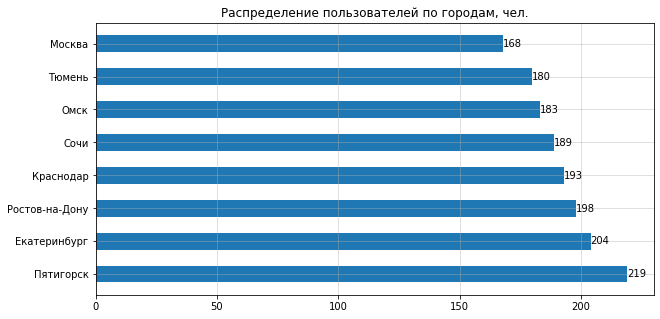

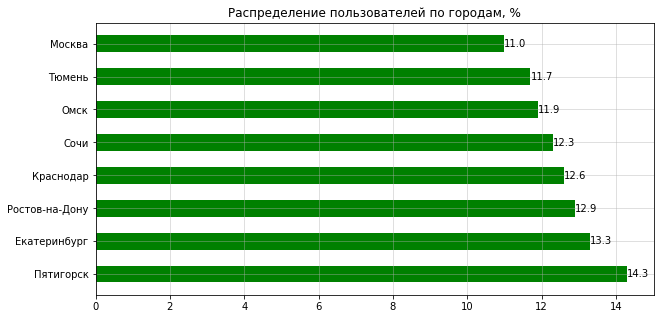

In [30]:
city_count = data_users['city'].value_counts().to_frame().reset_index()
city_count = city_count.rename(columns={'index': 'city', 'city': 'count'})
city_count['share'] = city_count['count'] / city_count['count'].sum()

# график со значениями в натуральном выражении

city = city_count['city']
count = city_count['count']

plt.figure(figsize=(10,5))
plt.barh(city, count, height=0.5)

for i in range(len(count)):
    plt.annotate(count[i], xy=(count[i],city[i]), ha='left', va='center')
   
plt.grid(alpha=0.5)
plt.title('Распределение пользователей по городам, чел.')

plt.show()

# график со значениями в процентах

city = city_count['city']
share = round(city_count['share'] * 100, 1)

plt.figure(figsize=(10,5))
plt.barh(city, share, height=0.5, color='green')

for i in range(len(share)):
    plt.annotate(share[i], xy=(share[i],city[i]), ha='left', va='center')
   
plt.grid(alpha=0.5)
plt.title('Распределение пользователей по городам, %')

plt.show()

<u>**Вывод:**</u> пользователи представлены в 8 городах, самое большое число пользователей в **Пятигорске** (**219 пользователей** или **14%**), наименьшее - в **Москве** (**168 пользователей** или **11%**). Число пользователей в городах не сильно отличается друг от друга.

### 3.2 Соотношение пользователей с подпиской и без подписки <a id="3.2"></a>

In [31]:
subscription_count = data_users['subscription_type'].value_counts()

subscription_count

free     835
ultra    699
Name: subscription_type, dtype: int64

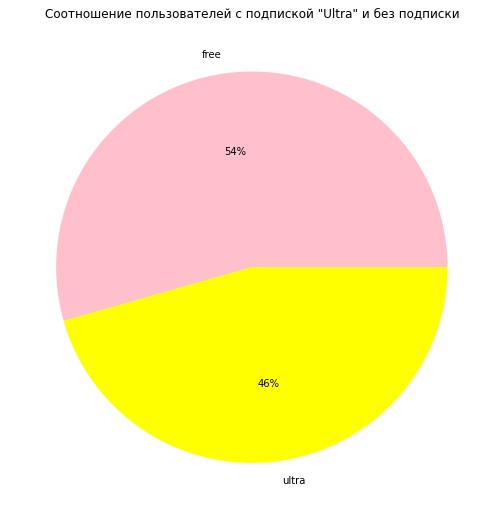

In [32]:
(subscription_count.plot(kind='pie',
                 y='subscription_type', 
                 figsize=(9,9), 
                 label='',
                 autopct='%1.0f%%',
                 colors=['pink','yellow'],
                 title='Соотношение пользователей с подпиской "Ultra" и без подписки')
)
plt.show()

<u>**Вывод:**</u> число пользователей **без подписки** - **835 чел.** или **54%**), с подпиской **"Ultra"** - **699 чел.** или **46%**).

### 3.3 Возраст пользователей <a id="3.3"></a>

**(1) Выведем данные описательной статистики**

In [33]:
print('Описательная статистика:')
data_users['age'].describe()

Описательная статистика:


count   1,534.00
mean       24.90
std         4.57
min        12.00
25%        22.00
50%        25.00
75%        28.00
max        43.00
Name: age, dtype: float64

**(2) Построим гистограмму**

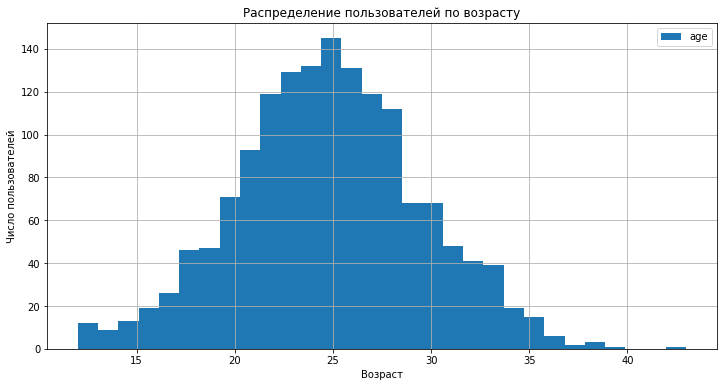

In [34]:
(data_users.plot(kind="hist",
                 y='age',
                 bins=30,
                 figsize=(12,6),
                 grid=True,
                 title='Распределение пользователей по возрасту')
)
plt.xlabel('Возраст')
plt.ylabel('Число пользователей')
plt.show()

На графике представлена гистограмма с нормальным распределением.

**(3) Построим диаграмму размаха**

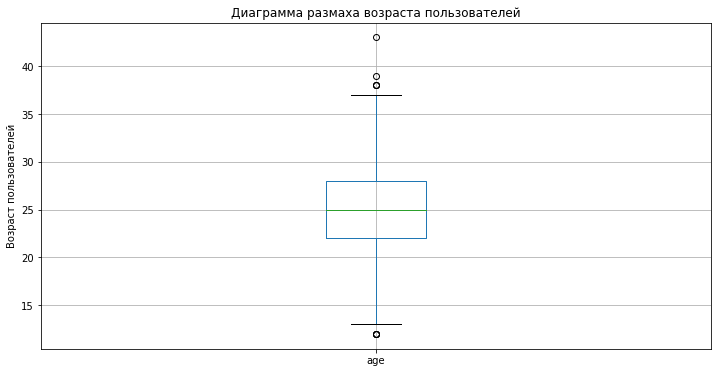

In [35]:
data_users.boxplot(column=['age'], figsize=(12,6), grid=True)

plt.title('Диаграмма размаха возраста пользователей')
plt.ylabel('Возраст пользователей')
plt.show()

<a id="first_summary_age"></a>
<u>**Промежуточный вывод:**</u> разброс пользователей по возрасту довольно широкий - **от 12 до 43 лет**. На диаграмме размаха несколько значений находятся за пределами 1,5 межквартильного размаха - 1,5 IQR), но в случае с возрастными пользователями эти значения нельязя считать выбросами, так как 40-летний человек вполне может взять в аренду самокат. **Сомнения вызывают пользователи до 18 лет**, так как у многих сервисов прокатов есть огранчения для данной группы пользователей. **Необходимо уточнить в условиях аренды минимальный возраст и допущения, согласно которым лицо, не достигшее 18-летнего возраста имеет право арендовать самокат**. **Пока что для анализа возьмём пользователей всех возрастов** и для наглядной интерпретации разделим их на следующие категории:

* до 18 лет;
* от 18 до 25 лет;
* от 26 до 35 лет;
* старше 35 лет.

**(4) Напишем функцию *'age_category'***

In [36]:
def age_category(row):
    age = row['age']
    if age < 18:
        return 'до 18 лет'
    if age >= 18 and age <= 25:
        return 'от 18 до 25 лет'
    if age >= 26 and age <= 35:
        return 'от 26 до 35 лет'
    return 'старше 35 лет'

# (5) добавим новый столбец 'age_category' в датафрейм

data_users['age_category'] = data_users.apply(age_category, axis=1)

Проанализируем данные:

In [37]:
age_count = data_users['age_category'].value_counts()

age_count

от 18 до 25 лет    782
от 26 до 35 лет    660
до 18 лет           79
старше 35 лет       13
Name: age_category, dtype: int64

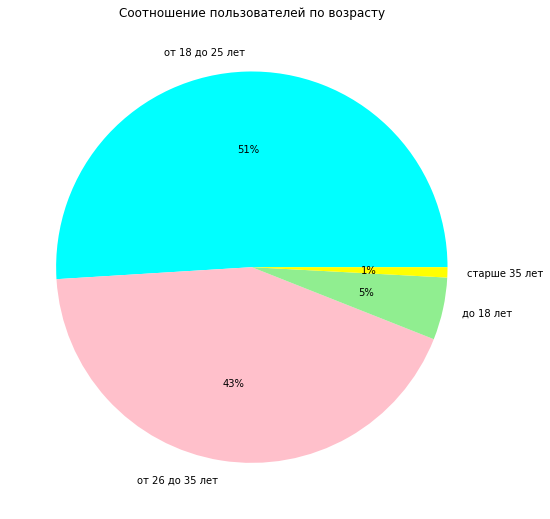

In [38]:
(age_count.plot(kind='pie',
                 y='age_category', 
                 figsize=(9,9), 
                 label='',
                 autopct='%1.0f%%',
                 colors=['cyan','pink','lightgreen','yellow'],
                 title='Соотношение пользователей по возрасту')
)
plt.show()

<u>**Вывод:**</u> **94%** пользователей составляют лица **от 18 до 35 лет** (категория от 18 до 25 лет и категория о 26 до 35 лет), то есть данную возрастную группу можно считать целевой аудиторией сервиса. Пользователей **старше 35 лет** всего **1%**, это говорит нам о том, что у людей средних лет и старшего поколения самокатшеринг не пользуется спросом. Также есть **5% категория подростков до 18 лет**, которая подлежит проверке из-за причин, описанных выше (см. [промежуточный вывод](#first_summary_age)).

### 3.4 Расстояние, которое пользователь преодолел за одну поездку <a id="3.4"></a>

**(1) Выведем данные описательной статистики**

In [39]:
print('Описательная статистика:')
data_rides['distance'].describe()

Описательная статистика:


count   18,068.00
mean     3,070.66
std      1,116.83
min          0.86
25%      2,543.23
50%      3,133.61
75%      3,776.22
max      7,211.01
Name: distance, dtype: float64

**(2) Построим гистограмму**

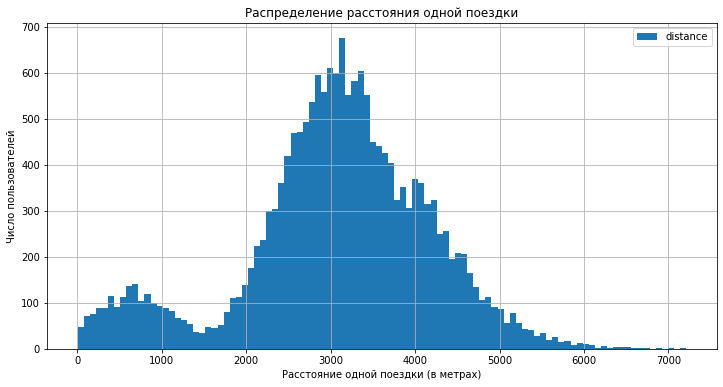

In [40]:
(data_rides.plot(kind="hist",
                 y='distance',
                 bins=100,
                 figsize=(12,6),
                 grid=True,
                 title='Распределение расстояния одной поездки')
)
plt.xlabel('Расстояние одной поездки (в метрах)')
plt.ylabel('Число пользователей')
plt.show()

На графике представлена гистограмма с бимодальным распределением (наблюдаются 2 пика).

**(3) Построим диаграмму размаха**

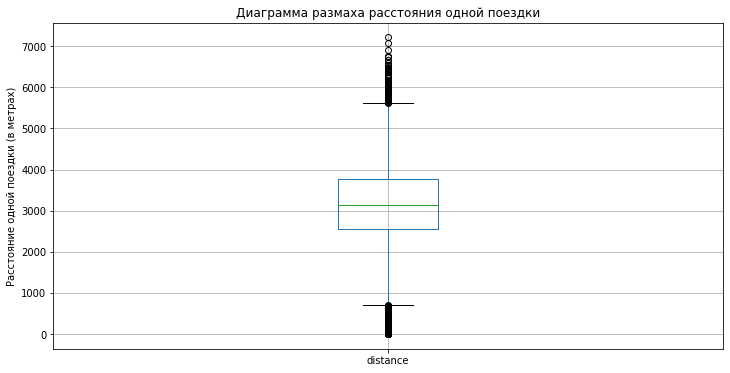

In [41]:
data_rides.boxplot(column=['distance'], figsize=(12,6), grid=True)

plt.title('Диаграмма размаха расстояния одной поездки')
plt.ylabel('Расстояние одной поездки (в метрах)')
plt.show()

**(4) Топ-10 самых коротких поездок по расстоянию**

In [42]:
short_rides = data_rides['distance'].sort_values(ascending=True).head(10)
print('Самые короткие поездки по расстоянию:')
short_rides

Самые короткие поездки по расстоянию:


11555    0.86
9541     2.57
13690    4.33
8658     6.78
7841     7.10
8906    11.28
8324    12.23
13940   15.00
15626   15.37
11862   15.63
Name: distance, dtype: float64

**(5) Топ-10 самых длинных поездок по расстоянию**

In [43]:
long_rides = data_rides['distance'].sort_values(ascending=False).head(10)
print('Самые длинные поездки по расстоянию:')
long_rides

Самые длинные поездки по расстоянию:


16309   7,211.01
16484   7,066.00
15580   6,908.49
17171   6,760.94
17242   6,724.93
10341   6,671.97
11385   6,601.20
12086   6,538.94
10915   6,535.39
11319   6,503.60
Name: distance, dtype: float64

<u>**Вывод:**</u> разброс данных по расстоянию одной поездки  - **от 0,86 до 7 211 метров (7,2 км)**. На диаграмме размаха множество значений находятся за пределами 1,5 межквартильного размаха - 1,5 IQR), но они не являются выбросами и будут использоваться для анализа, так как расстояния вполне адекватные. В основном пользователи проезжают **от 2,5 до 4 км**. Очень короткие поездки можно объянсить либо сбоем геолокации при отсутсвии какого-либо движения, либо решением пользователя сразу завершить поездку после начала аренды (из-за неисправности самоката, из-за внезапно начавшегося дождя, из-за появление другого вида транспорта для передвижения и т.д.).

### 3.5 Продолжительность поездок <a id="3.5"></a>

**(1) Выведем данные описательной статистики**

In [44]:
print('Описательная статистика:')
data_rides['duration'].describe()

Описательная статистика:


count   18,068.00
mean        17.81
std          6.09
min          0.50
25%         13.60
50%         17.68
75%         21.72
max         40.82
Name: duration, dtype: float64

**(2) Построим гистограмму**

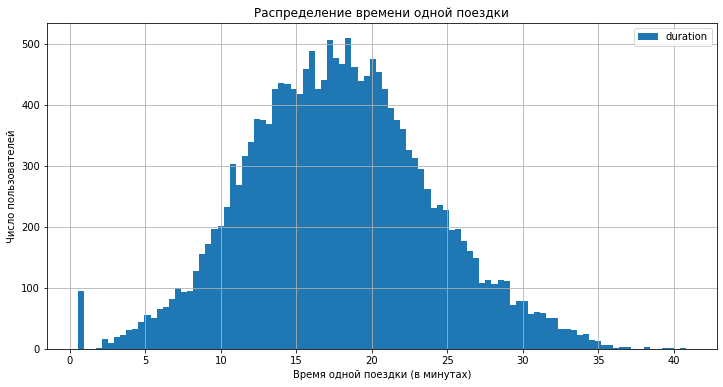

In [45]:
(data_rides.plot(kind="hist",
                 y='duration',
                 bins=100,
                 figsize=(12,6),
                 grid=True,
                 title='Распределение времени одной поездки')
)
plt.xlabel('Время одной поездки (в минутах)')
plt.ylabel('Число пользователей')
plt.show()

На графике представлена гистограмма с нормальным распределением, имеющая один выброс.

**(3) Построим диаграмму размаха**

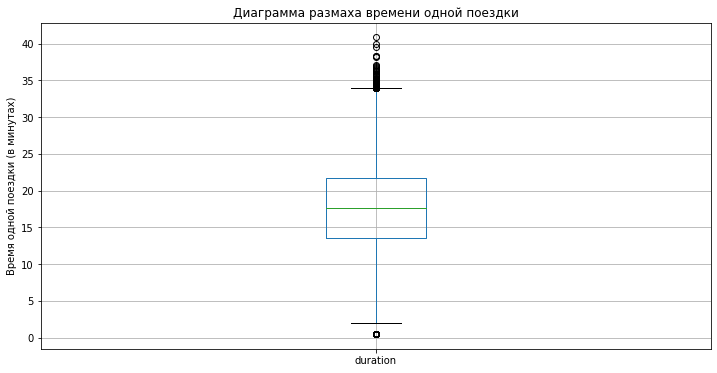

In [46]:
data_rides.boxplot(column=['duration'], figsize=(12,6), grid=True)

plt.title('Диаграмма размаха времени одной поездки')
plt.ylabel('Время одной поездки (в минутах)')
plt.show()

**(4) Топ-10 самых коротких поездок по времени**

In [47]:
short_time_rides = data_rides['duration'].sort_values(ascending=True).head(10)
print('Самые короткие поездки по времени:')
short_time_rides

Самые короткие поездки по времени:


12013   0.50
17314   0.50
15029   0.50
7437    0.50
12967   0.50
15015   0.50
13012   0.50
7508    0.50
16589   0.50
9049    0.50
Name: duration, dtype: float64

**(5) Топ-10 самых длинных поездок по времени**

In [48]:
long_time_rides = data_rides['duration'].sort_values(ascending=False).head(10)
print('Самые длинные поездки по времени:')
long_time_rides

Самые длинные поездки по времени:


4215   40.82
4709   39.87
2623   39.53
1998   38.35
6453   38.27
143    38.13
3729   37.01
499    36.91
6348   36.81
4653   36.62
Name: duration, dtype: float64

**(6) Дополнительная гистограмма для анализа коротких поездок**

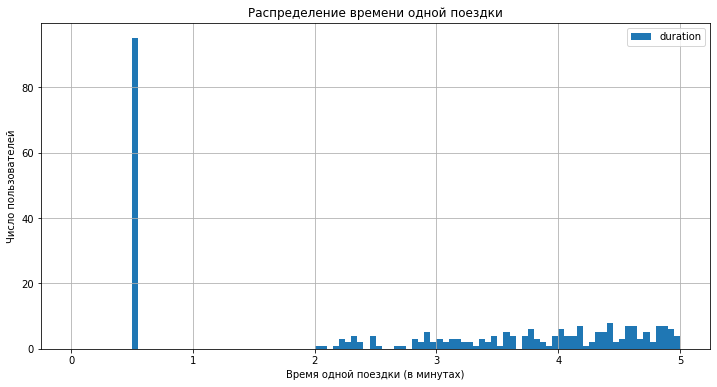

In [49]:
(data_rides.plot(kind="hist",
                 y='duration',
                 bins=100,
                 range=(0,5),
                 figsize=(12,6),
                 grid=True,
                 title='Распределение времени одной поездки')
)
plt.xlabel('Время одной поездки (в минутах)')
plt.ylabel('Число пользователей')
plt.show()

<u>**Промежуточный вывод:**</u> разброс данных по времени одной поездки  - **от 0,5 до 41 минуты**. На диаграмме размаха множество значений находятся за пределами 1,5 межквартильного размаха - 1,5 IQR), но **выбросом будем считать одно значение**, которое находится за пределами нижней границы 1,5 IQR. Речь идёт о значении **0,5**, которое встречается более 90 раз, что выглядит крайне странно. Даже, если 90 пользователей передумали ехать на самокате, **время аренды у них не может быть одинаковым**, тут либо имеет место технический сбой, либо это особенность приложения, которое по умолчанию фиксирует время в **0,5 минут**, если поездка была сразу завершена после её начала. Данный вопрос необходимо уточнить у разработчиков, но пока строки с этим значением будут удалены из анализа.

**(7) Сделаем срез данных и выведем обновлённую описательную статистику**

In [50]:
data_rides = data_rides.query('duration != 0.5').reset_index(drop=True)
data_rides['duration'].describe()

count   17,973.00
mean        17.90
std          5.98
min          2.04
25%         13.67
50%         17.71
75%         21.75
max         40.82
Name: duration, dtype: float64

**(8) Построим новую гистограмму**

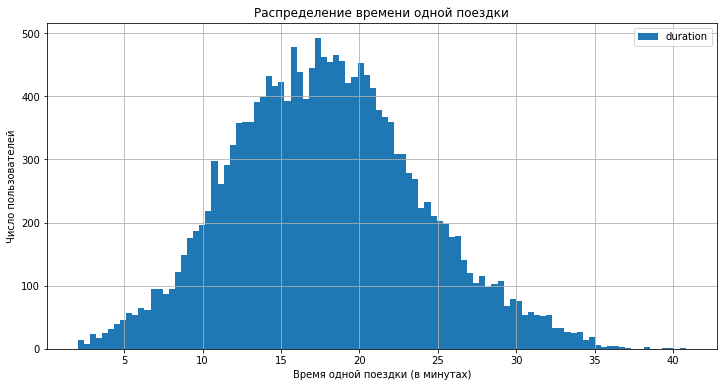

In [51]:
(data_rides.plot(kind="hist",
                 y='duration',
                 bins=100,
                 figsize=(12,6),
                 grid=True,
                 title='Распределение времени одной поездки')
)
plt.xlabel('Время одной поездки (в минутах)')
plt.ylabel('Число пользователей')
plt.show()

На графике представлена гистограмма с нормальным распределением и одним ярковыраженным пиком.

**(9) Построим новую диаграмму размаха**

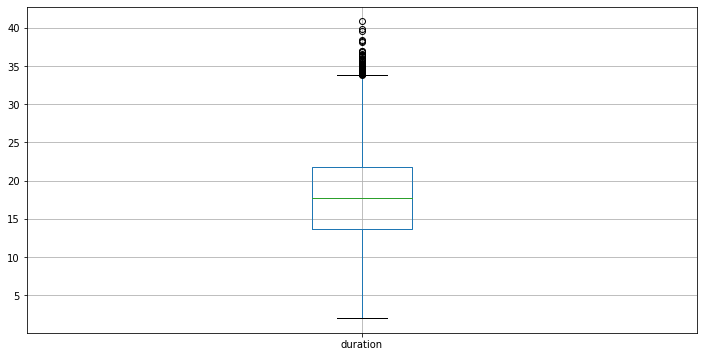

In [52]:
data_rides.boxplot(column=['duration'], figsize=(12,6), grid=True)
plt.show()

**(10) Обновлённый топ-10 самых коротких поездок по времени**

In [53]:
short_time_rides_new = data_rides['duration'].sort_values(ascending=True).head(10)
print('Самые короткие поездки по времени:')
short_time_rides_new

Самые короткие поездки по времени:


8885    2.04
6688    2.05
13249   2.18
17217   2.22
14017   2.22
14002   2.23
15531   2.25
6796    2.29
11965   2.32
10258   2.32
Name: duration, dtype: float64

**(11) Обновлённый топ-10 самых длинных поездок по времени**

In [54]:
long_time_rides = data_rides['duration'].sort_values(ascending=False).head(10)
print('Самые длинные поездки по времени:')
long_time_rides

Самые длинные поездки по времени:


4215   40.82
4709   39.87
2623   39.53
1998   38.35
6453   38.27
143    38.13
3729   37.01
499    36.91
6348   36.81
4653   36.62
Name: duration, dtype: float64

<u>**Вывод:**</u> разброс данных по времени одной поездки  - **от 2 до 41 минуты**. В основном одна поездка занимает **от 12 до 22 минут**. **Количество поездок более 35 минут - большая редкость**.

<a id="researchresults"></a>
### <u>**Результаты исследовательского анализа данных**</u>

1. Пользователи представлены в 8 городах, самое большое число пользователей в **Пятигорске** (**219 пользователей** или **14%**), наименьшее - в **Москве** (**168 пользователей** или **11%**).

2. Число пользователей **без подписки** - **835 чел.** или **54%**), с подпиской **"Ultra"** - **699 чел.** или **46%**).

3. **94%** пользователей составляют лица **от 18 до 35 лет** (категория от 18 до 25 лет и категория о 26 до 35 лет), то есть данную возрастную группу можно считать целевой аудиторией сервиса. Пользователей **старше 35 лет** всего **1%**, это говорит нам о том, что у людей средних лет и старшего поколения самокатшеринг не пользуется спросом. Также есть **5% категория подростков до 18 лет**, которая подлежит проверке из-за причин, описанных выше (см. [промежуточный вывод](#first_summary_age)).

4. За одну поездку пользователи обычно проезжают **от 2,5 до 4 км**.

5. Одна поездка занимает **от 12 до 22 минут**.

In [55]:
# проверка датасета data_rides после фильтрации

print(round(data_rides.shape[0] / size_rides, 2))
      
if round(data_rides.shape[0] / size_rides, 2) >= 0.9:
    print('\nДанные можно использовать для дальнейшего анализа')
else:
    print('\nДанные нельзя использовать для дальнейшего анализа')

0.99

Данные можно использовать для дальнейшего анализа


## Шаг 4. Объединение данных

### 4.1 Объединение данных о пользователях, поездках и подписках в один датафрейм

**(1) Объединим данные о пользователях, поездках и подписках в один датафрейм**

In [56]:
data_full = data_users.merge(data_rides)
data_full = data_full.merge(data_subscriptions)
data_full

,user_id,name,age,city,subscription_type,age_category,distance,duration,date,month,year,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,от 18 до 25 лет,"4,409.92",25.60,2021-01-01,1,2021,6,0,199
1,1,Кира,22,Тюмень,ultra,от 18 до 25 лет,"2,617.59",15.82,2021-01-18,1,2021,6,0,199
2,1,Кира,22,Тюмень,ultra,от 18 до 25 лет,754.16,6.23,2021-04-20,4,2021,6,0,199
3,1,Кира,22,Тюмень,ultra,от 18 до 25 лет,"2,694.78",18.51,2021-08-11,8,2021,6,0,199
4,1,Кира,22,Тюмень,ultra,от 18 до 25 лет,"4,028.69",26.27,2021-08-28,8,2021,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,Альберт,25,Краснодар,free,от 18 до 25 лет,"3,781.10",19.82,2021-11-04,11,2021,8,50,0
17969,1534,Альберт,25,Краснодар,free,от 18 до 25 лет,"2,840.42",21.41,2021-11-16,11,2021,8,50,0
17970,1534,Альберт,25,Краснодар,free,от 18 до 25 лет,"3,826.19",18.44,2021-11-18,11,2021,8,50,0
17971,1534,Альберт,25,Краснодар,free,от 18 до 25 лет,"2,902.31",16.67,2021-11-27,11,2021,8,50,0


**(2) Выведем сводную информацию по всему датасету**

In [57]:
data_full.info()

print('\nВсего строк:', data_full.shape[0])
print('Всего столбцов:', data_full.shape[1])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   name               17973 non-null  object        
 2   age                17973 non-null  int64         
 3   city               17973 non-null  object        
 4   subscription_type  17973 non-null  object        
 5   age_category       17973 non-null  object        
 6   distance           17973 non-null  float64       
 7   duration           17973 non-null  float64       
 8   date               17973 non-null  datetime64[ns]
 9   month              17973 non-null  int64         
 10  year               17973 non-null  int64         
 11  minute_price       17973 non-null  int64         
 12  start_ride_price   17973 non-null  int64         
 13  subscription_fee   17973 non-null  int64         
dtypes: dat

Пропусков в данных после объединения не появилось => данные можно использовать для дальнейшего анализа.

### 4.2 Создание дополнительных датафреймов

Создадим два датафрейма из датафрейма, созданного на этапе 4.1:

* c данными о пользователях без подписки;
* с данными о пользователях с подпиской.

**(1) Создадим датафрейм с данными о пользователях без подписки**

In [58]:
free_subscription = data_full.query('subscription_type == "free"').reset_index(drop=True)
free_subscription.head()

,user_id,name,age,city,subscription_type,age_category,distance,duration,date,month,year,minute_price,start_ride_price,subscription_fee
0,700,Айдар,22,Омск,free,от 18 до 25 лет,"2,515.69",14.94,2021-01-02,1,2021,8,50,0
1,700,Айдар,22,Омск,free,от 18 до 25 лет,846.93,16.23,2021-02-01,2,2021,8,50,0
2,700,Айдар,22,Омск,free,от 18 до 25 лет,"4,004.43",20.02,2021-02-04,2,2021,8,50,0
3,700,Айдар,22,Омск,free,от 18 до 25 лет,"1,205.91",9.78,2021-02-10,2,2021,8,50,0
4,700,Айдар,22,Омск,free,от 18 до 25 лет,"3,047.38",17.43,2021-02-14,2,2021,8,50,0


**(2) Создадим датафрейм с данными о пользователях с подпиской**

In [59]:
ultra_subscription = data_full.query('subscription_type == "ultra"').reset_index(drop=True)
ultra_subscription.head()

,user_id,name,age,city,subscription_type,age_category,distance,duration,date,month,year,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,от 18 до 25 лет,"4,409.92",25.60,2021-01-01,1,2021,6,0,199
1,1,Кира,22,Тюмень,ultra,от 18 до 25 лет,"2,617.59",15.82,2021-01-18,1,2021,6,0,199
2,1,Кира,22,Тюмень,ultra,от 18 до 25 лет,754.16,6.23,2021-04-20,4,2021,6,0,199
3,1,Кира,22,Тюмень,ultra,от 18 до 25 лет,"2,694.78",18.51,2021-08-11,8,2021,6,0,199
4,1,Кира,22,Тюмень,ultra,от 18 до 25 лет,"4,028.69",26.27,2021-08-28,8,2021,6,0,199


### 4.3 Визуализация информации о расстоянии и времени поездок

**Пользователи без подписки**

**(1) Визуализируем информацию о расстоянии поездок**

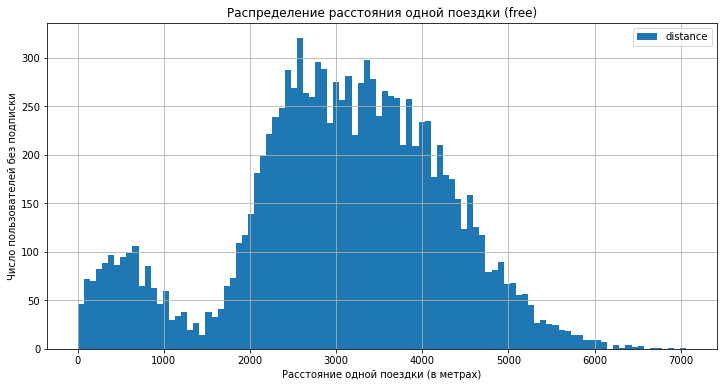

In [60]:
(free_subscription.plot(kind="hist",
                 y='distance',
                 bins=100,
                 figsize=(12,6),
                 grid=True,
                 title='Распределение расстояния одной поездки (free)')
)
plt.xlabel('Расстояние одной поездки (в метрах)')
plt.ylabel('Число пользователей без подписки')
plt.show()

На графике представлена гистограмма с бимодальным распределением (наблюдаются 2 пика).

**(2) Визуализируем информацию о времени поездок**

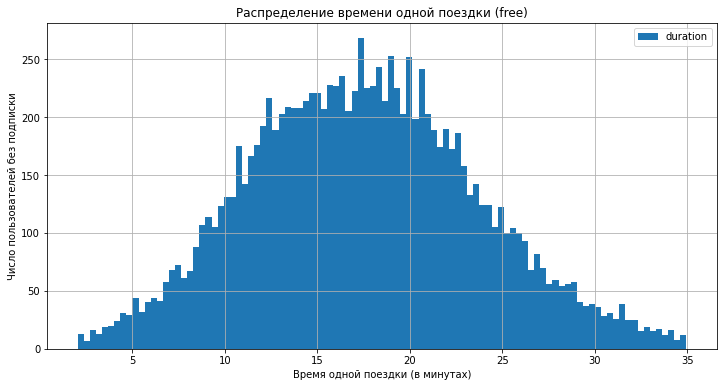

In [61]:
(free_subscription.plot(kind="hist",
                 y='duration',
                 bins=100,
                 figsize=(12,6),
                 grid=True,
                 title='Распределение времени одной поездки (free)')
)
plt.xlabel('Время одной поездки (в минутах)')
plt.ylabel('Число пользователей без подписки')
plt.show()

На графике представлена гистограмма с нормальным распределением и одним ярковыраженным пиком.

<u>**Вывод:**</u> пользователи без подписки в большинстве своём совершают поездки на расстояние **от 2 до 4,5 км**, и тратят на это **от 10 до 25 минут**. Самая длительная поездка не превышает **35 минут**. При этом два пика на графике говорят нам о том, что в зависимости от расстояния пользователи разделяются на 2 группы: многочисленную - **пользователи, которые проезжают больше 1 км** (они и составляют основу) и малочисленную - **пользователи, которые совершают короткие поездки до 1 км** (из-за отсутствия похожего пика на графике со врменем поездки можно предположить, что данные пользователи либо ездят  на максимальной скорости по прямой ровной дороге без препятствий, либо пренебрегают ПДД). Поскольку стоимость старта без подписки составляет 50 рублей, то пользователи стремятся преодолевать дистанцию за самое короткое время (если поездка не является прогулочной).

---
**Пользователи с подпиской Ultra**

**(1) Визуализируем информацию о расстоянии поездок**

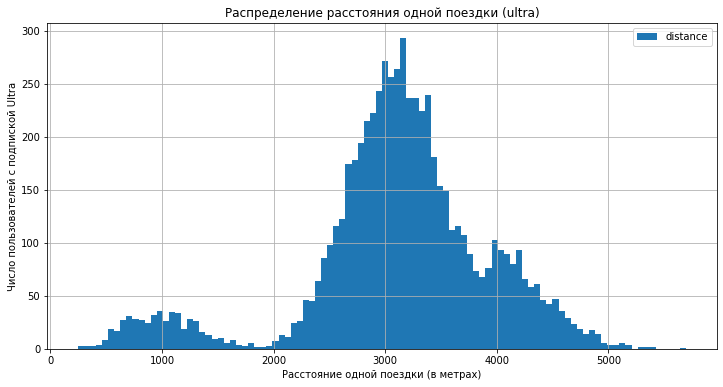

In [62]:
(ultra_subscription.plot(kind="hist",
                 y='distance',
                 bins=100,
                 figsize=(12,6),
                 grid=True,
                 title='Распределение расстояния одной поездки (ultra)')
)
plt.xlabel('Расстояние одной поездки (в метрах)')
plt.ylabel('Число пользователей c подпиcкой Ultra')
plt.show()

**(2) Визуализируем информацию о времени поездок**

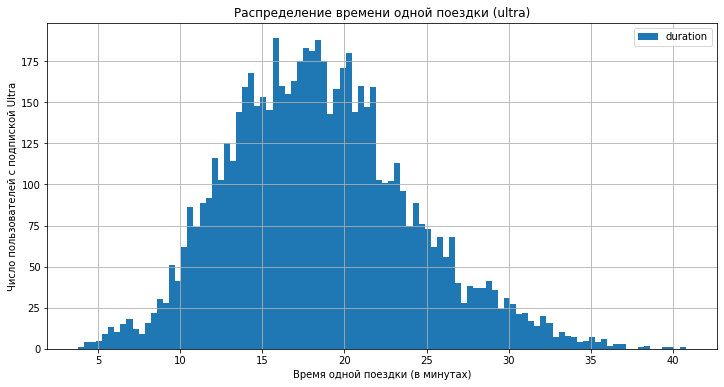

In [63]:
(ultra_subscription.plot(kind="hist",
                 y='duration',
                 bins=100,
                 figsize=(12,6),
                 grid=True,
                 title='Распределение времени одной поездки (ultra)')
)
plt.xlabel('Время одной поездки (в минутах)')
plt.ylabel('Число пользователей c подпиcкой Ultra')
plt.show()

<u>**Вывод:**</u> пользователи с подпиской Ultra в большинстве своём совершают поездки на расстояние **от 2,5 до 3,5 км**, и тратят на это **от 10 до 25 минут**. Самая длительная поездка занимает **более 40 минут**. Здесь также есть два пика на графике, но в отличие от графика с пользователями без подписки, здесь первый пик не так ярко выражен, иными словами, **пользователей, совершающих короткие поездки до 1 км** совсем мало. Имея подписку Ultra, людям не приходится платить дополнительные 50 рублей за старт, то есть мотивация преодолевать дистанцию за самое короткое время у них отстутствует. **Оформление подписки является признаком лояльности**: пользователь не только рассматривает элктросамокат как полноценнный вид транспорта, но и считает сервис и тарифы компании GoFast самыми лучшими на рынке.

<a id="mergeresults"></a>
### <u>**Результаты**</u>

1. Данные о пользователях, поездках и тарифах объединены в один датафрейм - **data_full**.

2. Созданы два датафрейма ина основе **data_full**:

* **free_subscription** - данные о пользователях без подписки;
* **ultra_subscription** -  данные о пользователях с подпиской.

3. Пользователи без подписки в большинстве своём совершают поездки на расстояние **от 2 до 4,5 км**, и тратят на это **от 10 до 25 минут**. Самая длительная поездка не превышает **35 минут**. 

4. Пользователи с подпиской Ultra в большинстве своём совершают поездки на расстояние **от 2,5 до 3,5 км**, и тратят на это **от 10 до 25 минут**. Самая длительная поездка занимает **более 40 минут**.

5. Пользователи с подпиской Ultra могут совершать более долгие поездки по времени, но по расстоянию они могут быть меньше, чем у пользователей без подписки. Это можно объяснить тем, что **пользователи без подписки стремятся преодолевать дистанцию за самое короткое время** (если поездка не является прогулочной), так как помимо поминутной оплаты им необходимо оплатить стартовый взнос в размере 50 рублей.

6. **Cравнение пользователей с подпиской Ultra и пользователей без подписки по 2-м парметрам:** Расстояние одной поездки (в метрах) и Время одной поездки (в минутах):

Text(0, 0.5, 'Число пользователей')

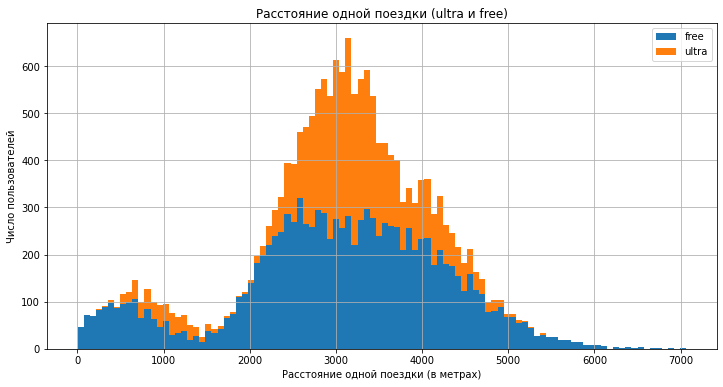

In [64]:
plt.figure(figsize=(12,6))
plt.grid()    

plt.hist([free_subscription['distance'], ultra_subscription['distance']], bins=100, stacked=True)     

plt.title('Расстояние одной поездки (ultra и free)')
plt.legend(['free', 'ultra'])
plt.xlabel('Расстояние одной поездки (в метрах)')
plt.ylabel('Число пользователей')

Text(0, 0.5, 'Число пользователей')

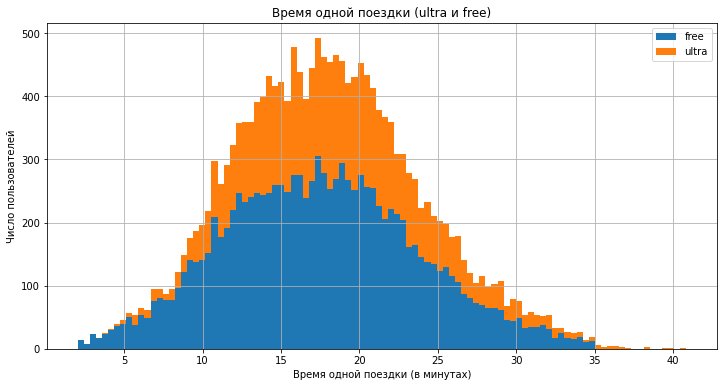

In [65]:
plt.figure(figsize=(12,6))
plt.grid()    

plt.hist([free_subscription['duration'], ultra_subscription['duration']], bins=100, stacked=True)     

plt.title('Время одной поездки (ultra и free)')
plt.legend(['free', 'ultra'])
plt.xlabel('Время одной поездки (в минутах)')
plt.ylabel('Число пользователей')

## Шаг 5. Подсчёт выручки

Для подсчёта выручки необходимо выполнить следующие действия:

1. Создать датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными: найти суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц;
2. В этот же датафрейм добавить столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого необходимо обратиться к информации об условиях оплаты для подписчиков и тех, у кого нет подписки ([см. условия оплаты](#payment)). 

**(1) Округлим значения из столбца `duration` до следующего целого числа**

In [66]:
data_full['duration'] = np.ceil(data_full['duration'])

**(2) Cформируем сводную таблицу, где будет отображена информация о суммарном расстоянии, количестве поeздок и суммарном времени для каждого пользователя за каждый месяц**

In [67]:
data_for_revenue = data_full.pivot_table(index=['month', 'user_id'],
                                         values = ['distance', 'duration', 'name', 'subscription_type'],
                                         aggfunc = {'distance': sum, 'duration' : sum, 'name' : len, 'subscription_type' : min})


**(3) Переименуем столбец `name` в `rides_number`, `duration` в `sum_duration`, `distance` в `sum_distance`**

In [68]:
data_for_revenue.rename(columns = {'name' : 'rides_number','duration' : 'sum_duration', 'distance' : 'sum_distance'}, inplace = True)

**(4) Выведем информацию по количеству пропущенных значений в каждом столбце:**

In [69]:
print(data_for_revenue.isna().sum())

total_isna = []
for value in data_for_revenue.isna().sum():
    if value != 0:
        total_isna.append(value)

print('\nКоличество столбцов с пропущенными значениями:', len(total_isna))

sum_distance         0
sum_duration         0
rides_number         0
subscription_type    0
dtype: int64

Количество столбцов с пропущенными значениями: 0


**(5) Выведем сводную таблицу на экран**

In [70]:
data_for_revenue.sort_values(by='month')

sum_distance  sum_duration  rides_number subscription_type
month user_id                                                            
1     1            7,027.51         42.00             2             ultra
      1059        11,979.29         74.00             3              free
      1061        12,637.25         43.00             3              free
      1063         3,276.36         10.00             1              free
      1064         5,297.32         15.00             1              free
...                     ...           ...           ...               ...
12    615          4,338.03         13.00             1             ultra
      616          5,997.44         35.00             2             ultra
      618          5,269.45         33.00             2             ultra
      597          3,753.72         26.00             1             ultra
      1534         2,371.71         16.00             1              free

[11300 rows x 4 columns]

На примере одного пользователя убедимся в корректности сводной таблицы:

**(6) Проверка корректности сводной таблицы**

In [71]:
check_pivot = data_for_revenue.query('user_id == 1')
check_pivot

,,sum_distance,sum_duration,rides_number,subscription_type
month,user_id,,,,
1,1,"7,027.51",42.00,2,ultra
4,1,754.16,7.00,1,ultra
8,1,"6,723.47",46.00,2,ultra
10,1,"5,809.91",32.00,2,ultra
11,1,"7,003.50",56.00,3,ultra
12,1,"6,751.63",28.00,2,ultra


Из вышепредставленных данных видно, что пользователь с id под номером 1 (имеющий подписку Ultra) совершил 12 поездок за 6 разных месяцев. 

**(7) Добавим в сводную таблицу столбец `sub_fee` с информацией об абонентской плате**

* без подписки — **отсутствует**;
* с подпиской Ultra — **199 рублей в месяц**

In [72]:
def sub_fee(row):
    sub = row['subscription_type']
    if sub == 'ultra':
        return 199
    return 0

data_for_revenue['sub_fee'] = data_for_revenue.apply(sub_fee, axis=1)

**(8) Добавим в сводную таблицу столбец `one_minute_cost` с информацией о стоимости одной минуты поездки**

* без подписки — **6 рублей**;
* с подпиской Ultra — **8 рублей**

In [73]:
def one_minute_cost(row):
    sub = row['subscription_type']
    if sub == 'ultra':
        return 6
    return 8

data_for_revenue['one_minute_cost'] = data_for_revenue.apply(one_minute_cost, axis=1)

**(9) Добавим в сводную таблицу столбец `start_cost` с информацией о стоимости старта**

* без подписки — **50 рублей**;
* с подпиской Ultra — **бесплатно**

In [74]:
def start_cost(row):
    sub = row['subscription_type']
    if sub == 'ultra':
        return 0
    return 50

data_for_revenue['start_cost'] = data_for_revenue.apply(start_cost, axis=1)

**(10) Добавим столбец `revenue_per_month` с помесячной выручкой**

In [75]:
a = data_for_revenue['sum_duration']
b = data_for_revenue['one_minute_cost']
c = data_for_revenue['sub_fee']
d = data_for_revenue['start_cost']
e = data_for_revenue['rides_number'] 

data_for_revenue['revenue_per_month'] = a * b + c + d * e

Вернёмся к пользователю с id под номером 1 и посмотрим, какую выручку он принёс компании в каждом месяце (месяцы, когда он арендовал электросамокат):

In [76]:
check_pivot_extra = data_for_revenue.query('user_id == 1')
check_pivot_extra

,,sum_distance,sum_duration,rides_number,subscription_type,sub_fee,one_minute_cost,start_cost,revenue_per_month
month,user_id,,,,,,,,
1,1,"7,027.51",42.00,2,ultra,199,6,0,451.00
4,1,754.16,7.00,1,ultra,199,6,0,241.00
8,1,"6,723.47",46.00,2,ultra,199,6,0,475.00
10,1,"5,809.91",32.00,2,ultra,199,6,0,391.00
11,1,"7,003.50",56.00,3,ultra,199,6,0,535.00
12,1,"6,751.63",28.00,2,ultra,199,6,0,367.00


Дополнительно проверим пользователя без подписка:

In [77]:
check_pivot_extra = data_for_revenue.query('user_id == 756')
check_pivot_extra

,,sum_distance,sum_duration,rides_number,subscription_type,sub_fee,one_minute_cost,start_cost,revenue_per_month
month,user_id,,,,,,,,
1,756,"3,172.11",25.00,1,free,0,8,50,250.00
2,756,"2,931.51",11.00,1,free,0,8,50,138.00
5,756,"4,916.91",40.00,2,free,0,8,50,420.00
6,756,"6,369.71",46.00,2,free,0,8,50,468.00
7,756,"2,381.10",20.00,1,free,0,8,50,210.00
9,756,"7,305.15",45.00,2,free,0,8,50,460.00
10,756,"2,161.61",14.00,1,free,0,8,50,162.00
11,756,"9,015.73",49.00,3,free,0,8,50,542.00
12,756,"2,444.26",23.00,1,free,0,8,50,234.00


In [78]:
data_for_revenue['revenue_per_month'].sum()

3873131.0

<a id="revenueresults"></a>
### <u>**Результаты**</u>

1. Создан датафрейм **data_for_revenue** с информацией о суммарном расстоянии (`sum_distance`), количестве поeздок (`rides_number`), суммарном времени (`sum_duration`) для каждого пользователя за каждый месяц;

2.  В датафрейм **data_for_revenue** добавлен столбец `revenue_per_month` с помесячной выручкой, которую принёс каждый пользователь. Выведен реультат для одного пользователя.

## Шаг 6. Проверка гипотез

### Гипотеза № 1

<u>**Вопрос заказчика**</u>: Тратят ли пользователи с подпиской больше времени на поездки?

**Проверка гипотезы:** пользователи с подпиской Ultra тратят больше времени на поездки, чем пользователи без подписки.

---
**H_0:** Время поездки пользователей (`duration`) по подписке Ultra = Время поездки пользователей пользователей (`duration`) без подписки.

**H_1:** Время поездки пользователей (`duration`) по подписке Ultra > Время поездки пользователей пользователей (`duration`) без подписки.

---
**alpha = 0.05**

In [79]:
ultra = ultra_subscription['duration'] 
free = free_subscription['duration']

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»

results = st.ttest_ind(ultra, 
                       free,
                       alternative='greater')

# зададим уровень статистической значимости

alpha = 0.05

# выведем на экран полученное p-значение

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 4.7044680744539e-28
Отвергаем нулевую гипотезу


<u>**Вывод:**</u> нулевая гипотеза отвергнута => время поездки пользователей по подписке Ultra **превышает** время поездки пользователей пользователей без подписки => **пользователи с подпиской Ultra являются «выгодными» для компании**.

### Гипотеза № 2

<u>**Вопрос заказчика**</u>: Расстояние одной поездки в 3 130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3 130 метров?

**Проверка гипотезы:** пользователи с подпиской Ultra проезжают расстояние, НЕ превышающее 3 130 метров в среднем за одну поездку.

---
**H_0:** Расстояние пользователей (`distance`) по подписке Ultra = 3130 метров.

**H_1:** Расстояние пользователей (`distance`) по подписке Ultra > 3130 метров.

<div class="alert alert-dan ger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />В данном случае стоит использовать параметр alternative = 'greater'. Поскольку оптимальное расстояние по износу составляет 3130 м, значит большее расстояние приводит к повышенному износу самоката. Следовательно, имеет смысл сформулировать альтернативную гипотезу "Подписчики в среднем проезжают расстояние больше оптимального"
</div>

---
**alpha = 0.05**

In [80]:
ultra_distance = ultra_subscription['distance'] 

interested_value = 3130

# проводим ttest для одной выборки, в качестве альтернативной используем одностороннюю гипотезу «больше»

results = st.ttest_1samp(ultra_distance, 
                       interested_value,
                       alternative='greater')

# зададим уровень статистической значимости

alpha = 0.05

# выведем на экран полученное p-значение

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


<u>**Вывод:**</u> не получилось отвергнуть нулевую гипотезу => пользователи с подпиской Ultra **могут проезжать расстояние, равное 3130 метров в среднем за одну поездку** => нельзя утверждать, что увеличение пользователей с подпиской ускорит износ электросамокатов.

### Гипотеза № 3

<u>**Вопрос заказчика**</u>: Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

**Проверка гипотезы:** помесячная выручка от пользователей с подпиской Ultra выше, чем выручка от пользователей без подписки.

---
**H_0:** Помесячная выручка пользователей (`revenue_per_month`) по подписке Ultra = Помесячная выручка пользователей (`revenue_per_month`) без подписки.

**H_1:** Помесячная выручка пользователей (`revenue_per_month`) по подписке Ultra > Помесячная выручка пользователей (`revenue_per_month`) без подписки.

---
**alpha = 0.05**

In [81]:
ultra_revnue_month = data_for_revenue.loc[data_for_revenue.subscription_type == 'ultra', 'revenue_per_month'] 
free_revnue_month = data_for_revenue.loc[data_for_revenue.subscription_type == 'free', 'revenue_per_month'] 

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»

results = st.ttest_ind(ultra_revnue_month, 
                       free_revnue_month,
                       alternative ='greater')

# зададим уровень статистической значимости

alpha = 0.05

# выведем на экран полученное p-значение

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 2.0314113674863288e-30
Отвергаем нулевую гипотезу


<u>**Вывод:**</u> нулевая гипотеза отвергнута => помесячная выручка пользователей по подписке Ultra **больше** помесячной выручки пользователей без подписки.

### Дополнительный вопрос

<u>**Вопрос**</u>: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

<u>**Ответ:**</u>

В данном случае необходимо использовать **гипотезу о равенстве средних для зависимых (парных) выборок**.  Мы будем проверять **одностороннюю гипотезу**, т.е. предположение о снижении количества обращений. Возможность их увеличения мы рассматривать не будем.

Гипотезы будут сформулированы так:

**H_0 : μ1 = μ2**

**H_1 : μ1 != (не равно) μ2**,

*где μ1 и μ2 - средние значения количество обращений в техподдержку до и после изменения.*

Для проверки гипотезы необходимо применить метод **scipy.stats.ttest_rel()**. Ему достаточно передать всего два параметра: наборы данных до и после. Оба набора должны быть одинаковыми по размеру: каждое измерение должно быть проведено до и после изменения.

## Шаг 7. Общий вывод

Для заказчика было проведено исследование данных сервиса GoFast о пользователях из нескольких городов, а также об их поездках. Цель исследования заключалась в следующем: выяснить, стоит ли продакт-менеджерам сервиса (далее - Заказчик) проводить различные акции для увеличиения количества пользователей с подпиской.

Для анализа заказчик предоставил **3 файла** в CSV-формате. В файлах были представлены следующие данные:

<u>**(1) Пользователи — users_go.csv</u>**

* **`user_id`** — уникальный идентификатор пользователя
* **`name`** — имя пользователя
* **`age`** — возраст
* **`city`** — город
* **`subscription_type`** — тип подписки (free, ultra)

<u>**(2) Поeздки — rides_go.csv</u>**

* **`user_id`** — уникальный идентификатор пользователя
* **`distance`** — расстояние, которое пользователь проехал в текущей сессии (в метрах)
* **`duration`** — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
* **`date`** — дата совершения поездки

<u>**(3) Подписки — subscriptions_go.csv</u>**

* **`subscription_type`** — тип подписки
* **`minute_price`** — стоимость одной минуты поездки по данной подписке
* **`start_ride_price`** — стоимость начала поездки
* **`subscription_fee`** — стоимость ежемесячного платежа

---
Сначала был проведён первичный анализ данных, где были выявлены проблемы в виде явных дубликатов и несоответствия типа данных столбцов описанию из документации. Подробнее см. **[Результаты и выявленные проблемы первичного анализа данных](#firstresults)**.

---
Затем проведена предобработка данных, после которой стало возможным использовать датафрейм для исследовательского анализа. Подробнее см. **[Результаты предобработки данных](#preprocessingresults)**.

---
На этапе исследовательского анализа были изучены и обработаны 5 параметров из **[списка](#parameters)**. По результатам анализа сформулированы следующие выводы:

1. Пользователи представлены в 8 городах, самое большое число пользователей в **Пятигорске** (**219 пользователей** или **14%**), наименьшее - в **Москве** (**168 пользователей** или **11%**).

2. Число пользователей **без подписки** - **835 чел.** или **54%**), с подпиской **"Ultra"** - **699 чел.** или **46%**).

3. **94%** пользователей составляют лица **от 18 до 35 лет** (категория от 18 до 25 лет и категория о 26 до 35 лет), то есть данную возрастную группу можно считать целевой аудиторией сервиса. Пользователей **старше 35 лет** всего **1%**, это говорит нам о том, что у людей средних лет и старшего поколения самокатшеринг не пользуется спросом. Также есть **5% категория подростков до 18 лет**, которая подлежит проверке из-за причин, описанных ранее (см. [промежуточный вывод](#first_summary_age)).

4. За одну поездку пользователи обычно проезжают **от 2,5 до 4 км**.

5. Одна поездка занимает **от 12 до 22 минут**.

---
Для дальнейшего анализа данные о пользователях, поездках и тарифах объединены в один датафрейм - **data_full**, а затем созданы два датафрейма ина основе **data_full**:

* **free_subscription** - данные о пользователях без подписки;
* **ultra_subscription** -  данные о пользователях с подпиской.

После этого детальному исследованию подверглась информация о расстоянии и времени поездок. Сформулированы следующие выводы:

1. Пользователи без подписки в большинстве своём совершают поездки на расстояние **от 2 до 4,5 км**, и тратят на это **от 10 до 25 минут**. Самая длительная поездка не превышает **35 минут**. 

2. Пользователи с подпиской Ultra в большинстве своём совершают поездки на расстояние **от 2,5 до 3,5 км**, и тратят на это **от 10 до 25 минут**. Самая длительная поездка занимает **более 40 минут**.

3. Пользователи с подпиской Ultra могут совершать более долгие поездки по времени, но по расстоянию они могут быть меньше, чем у пользователей без подписки. Это можно объяснить тем, что **пользователи без подписки стремятся преодолевать дистанцию за самое короткое время** (если поездка не является прогулочной), так как помимо поминутной оплаты им необходимо оплатить стартовый взнос в размере 50 рублей.

---
Для расчёта помесячной выручки, которую принёс каждый пользователь, создан датафрейм **data_for_revenue**. Подробнее см. **[Результаты подсчёта выручки](#revenueresults)**.

---
Проверены гипотезы:

**Гипотеза 1:** пользователи с подпиской Ultra тратят больше времени на поездки, чем пользователи без подписки.

<u>**Вывод:**</u> нулевая гипотеза отвергнута => время поездки пользователей по подписке Ultra **превышает** время поездки пользователей пользователей без подписки => **пользователи с подпиской Ultra являются «выгодными» для компании**.

---
**Гипотеза 2:** пользователи с подпиской Ultra проезжают расстояние, НЕ превышающее 3 130 метров в среднем за одну поездку.

<u>**Вывод:**</u> е получилось отвергнуть нулевую гипотезу => пользователи с подпиской Ultra **могут проезжать расстояние, равное 3130 метров в среднем за одну поездку** => нельзя утверждать, что увеличение пользователей с подпиской ускорит износ электросамокатов.

---
**Гипотеза 3:** помесячная выручка от пользователей с подпиской Ultra выше, чем выручка от пользователей без подписки.

<u>**Вывод:**</u> нулевая гипотеза отвергнута => помесячная выручка пользователей по подписке Ultra **больше** помесячной выручки пользователей без подписки.

---
**Ответ на дополнительный вопрос:** для проверки количества обращений необходимо использовать **гипотезу о равенстве средних для зависимых (парных) выборок**. Мы будем проверять **одностороннюю гипотезу**, т.е. предположение о снижении количества обращений. Возможность их увеличения мы рассматривать не будем.

**РЕЗУЛЬТИРУЮЩИЙ ВЫВОД:**

По результатам исследования можно утверждать, что увеличение количества пользователей с подпиской Ultra будет способстовать росту выручки компании, именно поэтому продакт-менеджерам сервиса следует проводить различные акции для достижения данной цели. Только пользователи с подпиской могут использовать электросамокат более 40 минут, так как они меньше тратят за одну минуту поездки и им не нужно платить стартовый взнос. Но следует учитывать тот факт, что пользователи с подпиской за одну поездку преодолевают большее расстояние, чем расстояние, считающееся оптимальным с точки зрения износа электросамокатов. Существует небольшая вероятность того, что увеличатся издержки на ремонт текущих электросамокатов и возникнет необходимость в увеличении размеров парка (электросамокатов).